This python notebook contains results of the following trading strategies on Chicago SRW Wheat Futures daily close data from Jan 2006 to Sept 2021:

1. Mean Reversion using Bollinger Bands
2. Moving Average Crossover 
3. Deep Learning Recurrent Neural Network (RNN) - Long Short Term Memory (LSTM)

# 1. Mean Reversion Strategy
Mean-Reversion assumes that from time to time financial instruments are extremely priced: either too high or too low and that extreme prices move back to average mean price over time

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product
plt.style.use('seaborn')

## 1.1 Getting Data

In [ ]:
# getting Chicago SRW Wheat Futures Close price from yahoo finance and saving to dataframe
data = yf.download('ZW=F', start = '2006-01-01', end = '2021-10-01')['Close'].to_frame()

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Close
Date,
2006-01-03,346.00
2006-01-04,346.25
2006-01-05,339.75
2006-01-06,330.75
2006-01-09,326.50


In [ ]:
# saving the dataframe as csv file
data.to_csv('wheat.csv')

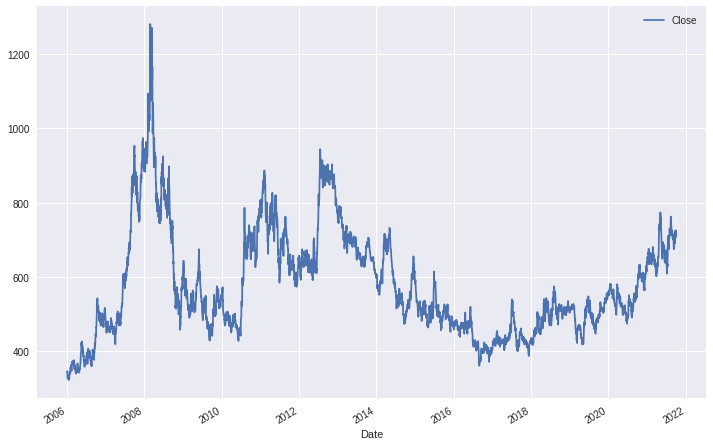

In [ ]:
# Plotting the data
data.plot(figsize = (12,8))
plt.show()

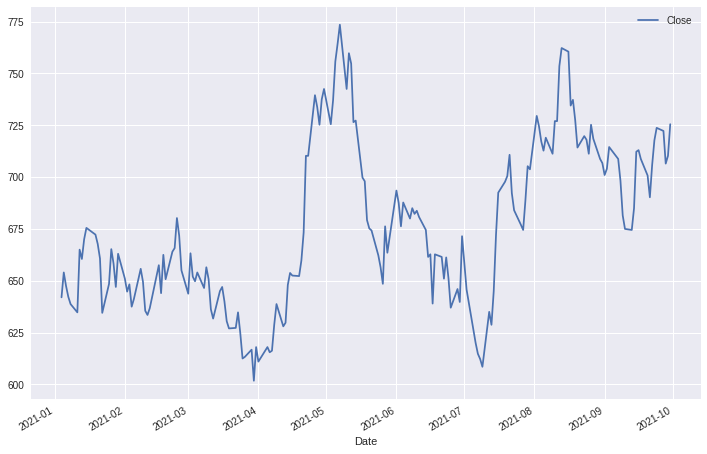

In [ ]:
# Plotting a zoomed in plot for 2021
data.loc['2021'].plot(figsize = (12,8))
plt.show()

## 1.2 Defining a Mean-Reversion Bollinger Bands backtester class

1. Mean Reversion: Financial Instruments are from time to time overbought/oversold and revert back to mean prices
2. Bollinger Bands: Consists of a Simple Moving Average SMA(e.g. 30) and Upper and Lower Bands +-(2) Std. Dev away from SMA

In [ ]:
class MeanRevBacktester():
    ''' Class for Vectorised Backtesting of Bollinger Bands based Mean-Reversion trading strategies.
    '''
    
    def __init__(self, symbol, SMA, dev, start, end, tc):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA: int
            moving window in bars (e.g. days) for SMA
        dev: int
            distance for upper/lower bands in Standard Deviation units
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        '''
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.prepare_data()
        
        
    def __repr__(self):
        rep = 'MeanRevBacktester (symbol = {}, SMA = {}, dev = {}, start = {}, end = {})'
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
    
    
    def get_data(self):
        ''' Imports data from the csv file (source can be changed here).
        '''
        # This is very similar to the get_data() method in SMA backtester class
        raw = pd.read_csv('wheat.csv', parse_dates = ['Date'], index_col = 'Date')
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start: self.end]
        raw.rename(columns = {self.symbol : 'Close'}, inplace = True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw
        
        
    def prepare_data(self):
        ''' Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data['SMA'] = data['Close'].rolling(self.SMA).mean()
        data['Lower'] = data['SMA'] - data['Close'].rolling(self.SMA).std() * self.dev
        data['Upper'] = data['SMA'] + data['Close'].rolling(self.SMA).std() * self.dev
        self.data = data
        
    
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters (SMA, dev) and the prepared dataset.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data['SMA'] = self.data['Close'].rolling(self.SMA).mean()
            self.data['Lower'] = self.data['SMA'] - self.data['Close'].rolling(self.SMA).std() * self.dev
            self.data['Upper'] = self.data['SMA'] + self.data['Close'].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data['Lower'] = self.data['SMA'] - self.data['Close'].rolling(self.SMA).std() * self.dev
            self.data['Upper'] = self.data['SMA'] + self.data['Close'].rolling(self.SMA).std() * self.dev
            
            
    def test_strategy(self):
        ''' Backtests the Bollinger Bands based trading strategy.
        '''
        data = self.data.copy().dropna()
        data['distance'] = data.Close - data.SMA
        data['position'] = np.where(data.Close < data.Lower, 1, np.nan)
        data['position'] = np.where(data.Close > data.Upper, -1, data['position'])
        data['position'] = np.where(data.distance * data.distance.shift(1) < 0, 0, data['position'])
        data['position'] = data.position.ffill().fillna(0)
        data['strategy'] = data.position.shift(1) * data['returns']
        data.dropna(inplace = True)
        
        # determining number of trades in each bar
        data['trades'] = data.position.diff().fillna(0).abs()
        
        # subtracting transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        
        # Absolute performance of strategy
        perf = data['cstrategy'].iloc[-1]
        
        # Out-Underperformance of strategy
        outperf = perf - data['creturns'].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to 'buy and hold'.
        '''
        if self.results is None:
            print('Run test_strategy() first.')
            
        else:
            title = '{} | SMA = {} | dev = {} | TC = {}'.format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[['creturns', 'cstrategy']].plot(title = title, figsize = (12,8))
            
            
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds the optimal strategy (global maximum) given the Bollinger Bands parameter ranges.
        
        Parameters
        ----------
        SMA_range, dev_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        combinations = list(product(range(*SMA_range), range(*dev_range)))
        
        # testing all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
            
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal paramters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
        
        # create a dataframe with many results
        many_results = pd.DataFrame(data = combinations, columns = ['SMA', 'dev'])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf

## 1.3 Backward and Forward Testing¶

1. A forward testing must be done on out-sample data, which the algorithm has not seen before to properly analyse the strategy's credentials
2. Data is separated into a training period and testing period

In [ ]:
# Specifying proportional trading costs
ptc = 0.00007

In [ ]:
# Creating an object train to backtest strategy
train = MeanRevBacktester('Close', 30, 2, '2006-01-01', '2017-12-31', ptc)

In [ ]:
# optimising SMA and std dev parameters. first tuple is for SMA range and the second one is for std dev range with step 1
train.optimize_parameters((25, 100, 1), (1,5,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

((94, 1), 3.733409)

__So we find that the most optimal Simple Moving Average Period to use would be 94 days, and the most optimum std dev would be 1. Applying these would have resulted in 373% return over the 12 year period from 2006-2018__

In [ ]:
# Accessing Results
train.results

,Close,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2006-05-18,418.50,-0.010695,355.007979,336.508217,373.507741,63.492021,-1.0,0.010695,0.0,0.989362,1.010753
2006-05-19,416.25,-0.005391,355.752660,336.228705,375.276614,60.497340,-1.0,0.005391,0.0,0.984043,1.016216
2006-05-22,426.25,0.023740,356.672872,335.911976,377.433769,69.577128,-1.0,-0.023740,0.0,1.007683,0.992375
2006-05-23,419.75,-0.015367,357.619681,336.040409,379.198952,62.130319,-1.0,0.015367,0.0,0.992317,1.007743
2006-05-24,411.75,-0.019243,358.526596,336.482850,380.570341,53.223404,-1.0,0.019243,0.0,0.973404,1.027322
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,424.75,-0.005283,424.667553,408.234675,441.100432,0.082447,0.0,-0.000000,0.0,1.004137,3.733409
2017-12-26,422.25,-0.005903,424.473404,408.121985,440.824823,-2.223404,0.0,-0.000000,0.0,0.998227,3.733409
2017-12-27,428.00,0.013526,424.353723,408.070593,440.636854,3.646277,0.0,0.000000,0.0,1.011820,3.733409


### Glossary: 
* __Close__ - Daily Chicago SRW Wheat Futures Close Price
* __returns__ - daily returns
* __SMA__ - Simple Moving Average Position
* __Lower__ - Lower Position of Bollinger Band (1 Standard deviation below)
* __Upper__ - Upper Position of Bollinger Band (1 Standard deviation above)
* __distance__ - Difference between Close price and SMA
* __position__ - -1 means short, 0.0 means neutral, +1 means long
* __strategy__ - returns made by following strategy
* __trades__ - number of trades on a day
* __creturns__ - Cumulative Buy and hold returns
* __cstrategy__ - Cumulative strategy returns

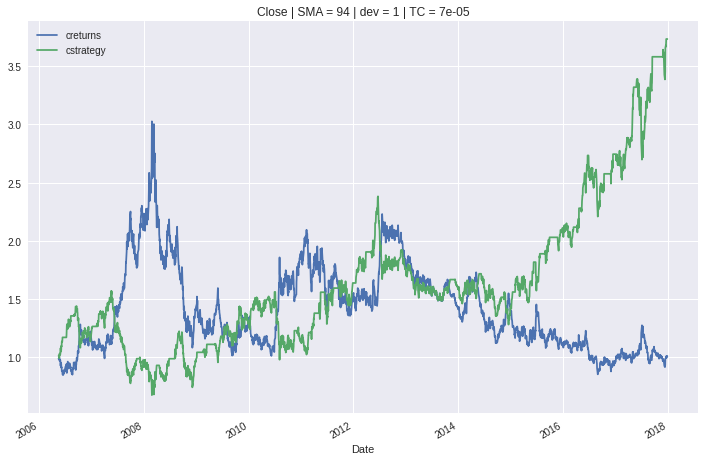

In [ ]:
# Plotting results
train.plot_results()

In [ ]:
# Creating a tester object to forward test strategy on out-sample data
tester = MeanRevBacktester('Close', 74, 1, '2018-01-01', '2021-10-01', ptc)

In [ ]:
# Testing optimised strategy for outsample data
tester.test_strategy()

(1.900666, 0.374101)

__In forward test our strategy delivers absolute performance of 190% and outperforms buy and hold by 37%__

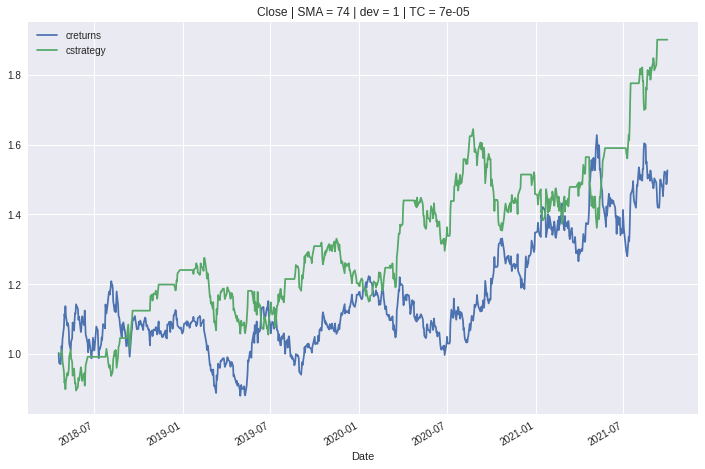

In [ ]:
# plotting results for out sample test
tester.plot_results()

# 2. Moving Average Crossover Strategy
The idea behind a Moving Average Crossover is simple: When the faster moving average falls below slower moving average, SELL. And buy in the opposite case.

In [ ]:
# Creating an SMABacktester class

class SMABacktester():
    ''' Class for Vectorised backtesting of SMA-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        start: str
            start date for data import
        end: str
            end date for data import
        '''
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()
        
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, 
                                                                self.SMA_S, self.SMA_L, self.start, self.end)
        
        
    def get_data(self):
        ''' Imports the data from forex_pairs.csv (source can be changed).
        '''
        raw = pd.read_csv('wheat.csv', parse_dates = ['Date'], index_col = 'Date')
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start : self.end].copy()
        raw.rename(columns = {self.symbol : 'Close'}, inplace = True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw
    
    
    def prepare_data(self):
        ''' Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data['SMA_S'] = data['Close'].rolling(self.SMA_S).mean()
        data['SMA_L'] = data['Close'].rolling(self.SMA_L).mean()
        self.data = data
    
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S 
            self.data['SMA_S'] = self.data['Close'].rolling(self.SMA_S).mean() 
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data['SMA_L'] = self.data['Close'].rolling(self.SMA_L).mean()
            
           
    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA_S'] > data['SMA_L'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace = True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
    
        perf = data['cstrategy'].iloc[-1] 
        outperf = perf - data['creturns'].iloc[-1] 
        return round(perf, 6), round(outperf,6)
    
    
    def plot_results(self):
        ''' Plots the performance of trading strategy and compares to 'buy and hold'.
        '''
        if self.results is None:
            print('Run test_strategy() first.')
        else:
            title = '{} | SMA_S = {} | SMA_L = {}'.format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[['creturns', 'cstrategy']].plot(title = title, figsize = (12,8))
            
            
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.
        
        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
      
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
            
        best_perf = np.max(results) 
        opt = combinations[np.argmax(results)] 
    
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
      
        many_results = pd.DataFrame(data = combinations, columns = ['SMA_S', 'SMA_L'])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf

## 2.1 Backwards and forwards testing

In [ ]:
# Initialising backtester by creating an training set for our data and choose SMA_S as 50 and SMA_L as 200
train1 = SMABacktester('Close', 50, 200, '2006-01-01', '2017-12-31')

In [ ]:
# optimising SMA_S between 25 and 50, and SMA_L between 100 and 200
train1.optimize_parameters((25, 50, 1), (100, 200, 1))

((28, 113), 1.977968)

__We find that the most optimal SMA_S is 28 and SMA_L is 113. If we had used this combination of moving averages, we would have generated 197% returns over the 12 year period between 2006 and 2018__

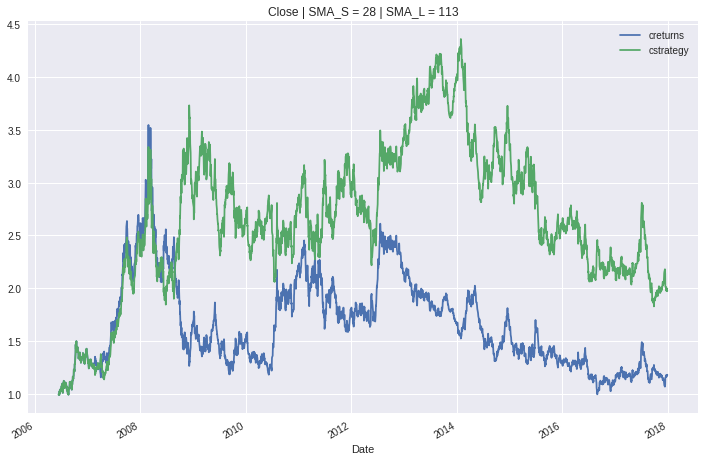

In [ ]:
# PLotting test results
train1.plot_results()

__Note: It is interesting to note that this moving average strategy really struggled after 2014. It could have occured due to the systemic shift in the markets brought upon by the commodity market crash__

In [ ]:
# forward testing the moving average crossover strategy using 28 and 113 as parameters
tester1 = SMABacktester('Close', 28, 113, '2018-01-01', '2021-10-01')

In [ ]:
# checking results of forward test
tester1.test_strategy()

(0.488472, -0.916175)

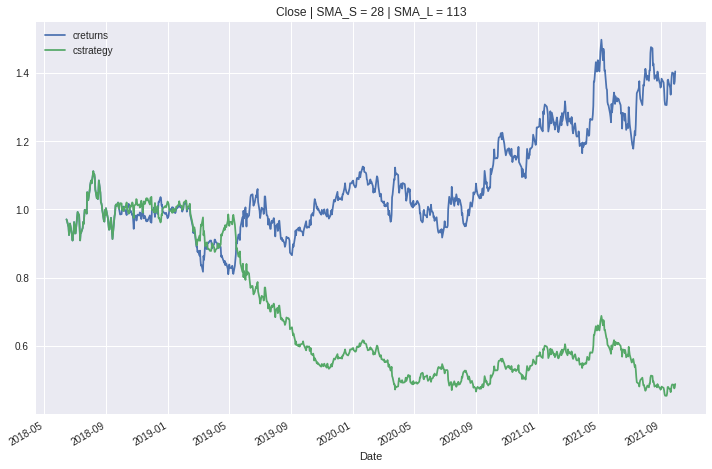

In [ ]:
tester1.plot_results()

__Our strategy did horrible in test period. It could not beat the buy and hold strategy. we ended up losing 50% of our investment. Buy and hold gave almost 40% positive returns__

# 3. Recurrent Neural Network (RNN) - Long Short Term Memory (LSTM) Strategy

Our aim is to predict the Chicago SRW Wheat Futures price using an LSTM model


## 3.1 Data Preprocessing

### Importing training set

Keeping separate the training and test set so that RNN is not acquainted with test set.

Creating a numpy array from the open price column using iloc because that is what we are interested in

In [ ]:
dataset_train = pd.read_csv('wheat_train.csv')
training_set = dataset_train.iloc[:, 1:2].values
# : selects all the rows. we use  1:2 for selecting column 2 because that lower bound is selected and upper bound is ingnored

### Feature Scaling
Two common ways of applying Feature Scaling are:

Standardisation X(stand) = [X - mean(X)] / stdev(X)

Normalisation X(norm) = [X - min(X)] / [max(X) - min(X)]

If there is a sigmoid activation function involved in the construction of an RNN, it is recommended to apply Normalisation. MinMaxScalar class from scikit learn library is used to do this

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# creating an object sc in minmaxscalar class. Normalising(Scaling) stock prices between 0 and 1
sc = MinMaxScaler(feature_range = (0,1))
# using fit_transform method for scaling training_set
training_set_scaled = sc.fit_transform(training_set)

### Number of timesteps and output
This datastructure specifies what our RNN needs to remember when predicting next day's price.

It is important to have an optimal number of timesteps or else it might lead to overfitting or non-sense predictions

Here we choose 60 timesteps (approx. 3 months since we have daily data) and 1 output. This means that our RNN will try to learn from 60 past prices to understand some trend and on the basis of that, it will predict the next price

In [ ]:
# Creating empty lists for inputs to Neural Network (x_train) and output (y_train)
# for each day x_train will contain 60 previous day prices, and y_train will contan next day's predicted price
x_train = []
y_train = []
# populating these empty lists with a for loop. we need to start with the 61st observation to get 60 previous prices
# Total observations in training set are 2994
for i in range(60, 2995):
  x_train.append(training_set_scaled[i-60 : i, 0]) # choosing previous 60 observations in column 1 (We only have one column)
  y_train.append(training_set_scaled[i , 0])
# creating a numpy array with these lists
x_train, y_train = np.array(x_train), np.array(y_train)

### Reshaping
Adds the number of predictors to predict wheat futures prices. This could be other commodity's prices or another time-series data. It is done using input_dim Keras expects inputs for RNN as N-D tensor with shape [batch_size, timesteps, ...] or [timesteps, batch_size, ...] when time_major is True.

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# selecting number of rows uisng [0] and number of columns using [1]. The 1 at the end is the number of predictors

## 3.2 Building an RNN
a stacked LSTM with dropout regularisation to avoid overfitting

### Importing Keras libraries and packages

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN
Initialise the Reccuring Neural Network as a sequence of layers.

We are predicting continuous outcomes (prices), hence we need to perform regression

In [ ]:
regressor = Sequential()

### Adding first LSTM layer and dropout regularisation
it is better to choose a large number of units(neurons) for higher dimensionality. Return sequences is set to True because we have multiple layers. Using dropout we can specify the number of neurons to ignore during regularisation. Here we use 20% dropout. So during forward and backpropagation 20% of neurons (10) will be ignored

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding second LSTM layer and dropout regularisation
we do not need to specify the input shape again when adding next LSTM layer

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding third LSTM layer and dropout regularisation
same as above

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding fourth LSTM layer and dropout regularisation
Since, this is the final layer of our RNN, we set return_sequences to False or remove it, because we are not returning any sequences here

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

### Adding the output layer
Since we only have one predicted output (price) we have one unit. Dense class is fully connected to other layers, so we use it for output

In [ ]:
regressor.add(Dense(units = 1))

### Compiling the RNN
A lot of optimisers can be used. Keras suggests to use RMSprop for RNN networks https://keras.io/api/optimizers/. We can also try Adam optimiser to see the difference later

In [ ]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

### Fitting the RNN to the Training Set
If we try to minimise the loss to an extreme extent, it would indicate overfitting

In [ ]:
regressor.fit(x = x_train, y = y_train, batch_size = 32, epochs = 100 )

Epoch 1/100
92/92 [==============================] - 18s 122ms/step - loss: 0.0084
Epoch 2/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0045
Epoch 3/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0035
Epoch 4/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0027
Epoch 5/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0026
Epoch 6/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0022
Epoch 7/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0020
Epoch 8/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0018
Epoch 9/100
92/92 [==============================] - 11s 123ms/step - loss: 0.0016
Epoch 10/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0017
Epoch 11/100
92/92 [==============================] - 11s 121ms/step - loss: 0.0015
Epoch 12/100
92/92 [==============================] - 11s 122ms/step - loss: 0.0013
E

## Part 3: Making Predictions and Visualising Results
Getting the real Chicago SRW Wheat Futures price

In [ ]:
dataset_test = pd.read_csv('wheat_test.csv')
real_price = dataset_test.iloc[:, 1:2].values

### Predicting price for Chicago SRW Wheat Futures
We would need to concatenate prices from the training set to test set so that for each day in test set we have access to previous 60 day open prices

But concatenation need to be performed on original dataset_train and dataset_test. From this concatenation we would get input from each prediction (i.e. the 60 previous prices at each time t), which will then be scaled. We are only scaling the inputs and not changing actual test values.

We need to scale inputs here because our RNN was trained on scaled inputs

In [ ]:
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0) # for vertical concatenation, axis = 0
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values
# we are choosing 60 previous values from dataset_train for our prediction number 1
inputs = inputs.reshape(-1, 1) # this gets input for stock prices in 1 column
inputs = sc.transform(inputs) 
# scaling the inputs. do not need to use fit_transform because sc object was already fitted to training set
# scaling must be the same on which our regressor was trained

In [ ]:
# we do not need y_test because we making predictions
# the test set contains 936 financial days so the upper bound in for loop would be 60+936 = 996
x_test = []
for i in range (60, 996):
  x_test.append(inputs[i-60 : i, 0])
x_test = np.array(x_test)
# creating a 3-d structure for keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# saving predictions in predicted_stock_price
predicted_price = regressor.predict(x_test)
# applying the inverse transform scaling method to get unscaled values
predicted_price = sc.inverse_transform(predicted_price)

### Visualising the results

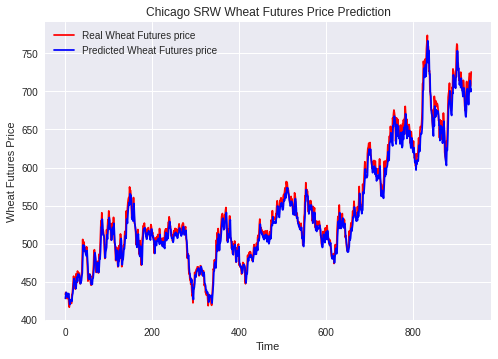

In [ ]:
# plotting the real Chicago SRW Wheat Futures price
plt.plot(real_price, color = 'red', label = 'Real Wheat Futures price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Wheat Futures price')
plt.title('Chicago SRW Wheat Futures Price Prediction')
plt.xlabel('Time')
plt.ylabel('Wheat Futures Price')
plt.legend()
plt.show()

In most parts of our predictions we see predicted results lagging the actual price. Our model can not react fast enough to sudden chances, But model reacts very well to smooth changes and manages to follow the trend

## Part 4: Closing Comments
Some ways to further improve the RNN model:

Getting more training data

Increasing the number of timesteps

Adding some other indicators (other stocks which might be correlated to our chosen stock

Adding more LSTM layers: this RNN had four LSTM layers but it could be experimented with

Adding more neurons in the LSTM layers